In [340]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import gc

from sklearn import ensemble
from matplotlib import style
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor

style.use('fivethirtyeight')
%matplotlib inline

TEST_DATASET_PATH = '/kaggle/input/realestatepriceprediction/test.csv'
TRAIN_DATASET_PATH = '/kaggle/input/realestatepriceprediction/train.csv'

test_data = pd.read_csv(TEST_DATASET_PATH)
train_data = pd.read_csv(TRAIN_DATASET_PATH)

In [341]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if (col_type != object) and (str(col_type) != 'category'):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif col_type == object:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [342]:
class FeatureImputer:
    """Заполнение пропусков и облработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] > 300) | (X['KitchenSquare'] < 5), 'KitchenSquare_outlier'] = 1
        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 0
        X.loc[X['KitchenSquare'] > 300, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < 12) & (X['LifeSquare'] > 12), 'Square_outlier'] = 1
        X.loc[(X['Square'] < 12) & (X['LifeSquare'] > 12), 'Square'] =\
            (X.loc[(X['Square'] < 12) & (X['LifeSquare'] > 12), 'LifeSquare'] +\
            X.loc[(X['Square'] < 12) & (X['LifeSquare'] > 12), 'KitchenSquare'])
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] > 50) | (X['HouseYear'] < 1900) | (X['HouseYear'] > 2020), 'HouseYear_outlier'] = 1
        X.loc[(X['HouseFloor'] > 50) | ((X['HouseFloor'] <= 1) & (X['Floor'] > 1)), 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[(X['HouseFloor'] <= 1) & (X['Floor'] <= 1), 'HouseFloor'] = 1
        X.loc[(X['HouseFloor'] < X['Floor']), 'HouseFloor'] = X.loc[(X['HouseFloor'] < X['Floor']), 'HouseFloor'] +\
            X.loc[(X['HouseFloor'] < X['Floor']), 'Floor']
        
        # HouseYear
        X['HouseYear_outlier'] = 0
        X.loc[(X['HouseYear'].isna()) | (X['HouseYear'] < 1900) | (X['HouseYear'] > 2020), 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'].isna() | (X['HouseYear'] < 1900) | (X['HouseYear'] > 2020), 'HouseYear'] = self.medians['HouseYear']
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
                        
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] =\
            (X.loc[X['LifeSquare'] > X['Square'], 'Square'] - X.loc[X['LifeSquare'] > X['Square'], 'KitchenSquare'])
        
        return X

In [343]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.binary_to_numbers = None
        self.average_price_per_square_meter = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        
        district = district[district > 50] 
        self.DistrictId_counts = district.to_dict()
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()     
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
            df['PricePerSquareMeter'] = df['Price'] / df['Square']
            self.average_price_per_square_meter = df.groupby('DistrictId_popular', as_index=False).\
                                                agg({'PricePerSquareMeter':'median'}).\
                                                rename(columns={'PricePerSquareMeter':'AveragePricePerSquareMeter',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            


        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X) 
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on='DistrictId', how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.average_price_per_square_meter is not None:
            X = X.merge(self.average_price_per_square_meter, on='DistrictId', how='left')
            
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X

In [344]:
def evaluate_preds(true_values, pred_values, save=False):
    '''Оценка качества модели и график preds vs true'''
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
         "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" + 
         "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 550000], [0, 550000], linestyle='--', color='black') # диагональ где true_values = pred_value
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [345]:
train_data = reduce_mem_usage(train_data)
test_data = reduce_mem_usage(test_data)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [346]:
train_data = train_data[(train_data['Square'] > 8)]

In [347]:
X = train_data.drop('Price', axis=1)
y = train_data[['Price']]

In [348]:
preds_final = pd.DataFrame()
preds_final['Id'] = test_data['Id'].copy()

In [349]:
X.set_index('Id', inplace=True)
test_data.set_index('Id', inplace=True)

In [350]:
print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', test_data.shape[0])

# Удалим ненужные файлы
del train_data 
gc.collect()  

Строк в трейне: 9988
Строк в тесте 5000


2668

In [351]:
imputer = FeatureImputer()
imputer.fit(X)

X = imputer.transform(X)
test_data = imputer.transform(test_data)

In [352]:
features = FeatureGenetator()
features.fit(X, y)

X = features.transform(X)
test_data = features.transform(test_data)

In [353]:
lgb_model = LGBMRegressor(criterion='mse', min_samples_leaf=15,
                         random_state=42)

In [354]:
params = {'n_estimators': [150, 200, 400],
         'max_depth': [5, 7, 10]}

In [355]:
gs = GridSearchCV(lgb_model, params, 
                 scoring='r2', # метрика
                 cv=KFold(n_splits=7, # k кол-во разбиений/итераций в кросс валидации
                         random_state=21,
                         shuffle=True),
                 n_jobs=-1 # кол-во потоков
                 )

In [356]:
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=7, random_state=21, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=15, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10],

In [357]:
gs.best_params_

{'max_depth': 10, 'n_estimators': 150}

In [358]:
gs.best_score_

0.7508654262104774

In [359]:
final_model = LGBMRegressor(criterion='mse',
                           max_depth=10,
                           min_samples_leaf=15,
                           random_state=42,
                           n_estimators=150)
final_model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              criterion='mse', importance_type='split', learning_rate=0.1,
              max_depth=10, min_child_samples=20, min_child_weight=0.001,
              min_samples_leaf=15, min_split_gain=0.0, n_estimators=150,
              n_jobs=-1, num_leaves=31, objective=None, random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [361]:
y_train_preds = final_model.predict(X)

In [362]:
y_test_pred = final_model.predict(test_data)

In [363]:
feature_importance = pd.DataFrame(zip(X.columns, 
                                      final_model.feature_importances_ / final_model.feature_importances_.sum()),
                                 columns=['feature_name', 'importance'])

feature_importance.sort_values(by='importance', ascending=False, inplace=True)

In [364]:
feature_importance

,feature_name,importance
2,Square,0.139602
3,LifeSquare,0.088675
7,HouseYear,0.088229
0,DistrictId,0.086442
8,Ecology_1,0.069466
6,HouseFloor,0.067679
13,Social_3,0.055841
4,KitchenSquare,0.053384
5,Floor,0.053161
29,AveragePricePerSquareMeter,0.045566


In [365]:
preds_final['Price'] = y_test_pred

R2:	0.885
RMSE:	31441.356
MSE:	988558863.002


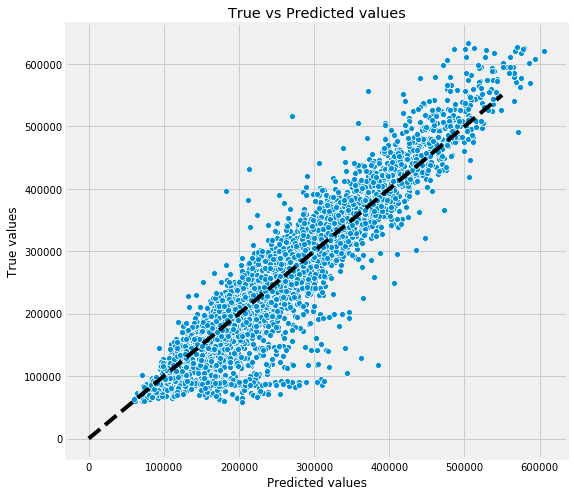

In [366]:

evaluate_preds(y['Price'], y_train_preds)

In [367]:
X['LifeSquare'].median()

36.9094123840332

In [368]:
preds_final.to_csv('predictions.csv', index=False)

In [369]:
preds_final.shape

(5000, 2)